# Extract the dominant colors of skin, eyes and hair

In [88]:
import cv2
import numpy as np
import dlib
import Queue
import matplotlib.pyplot as plt
import glob
import time
from collections import OrderedDict
from IPython.core.debugger import Tracer
%matplotlib inline

In [2]:
FACIAL_LANDMARKS_IDXS = OrderedDict([
    #("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)), # hair
    #("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)), # eye
    #("left_eye", (42, 48)),
    ("nose", (27, 35)), # skin
    #("jaw", (0, 17))
])

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

# Image is already a face no need to extract the face
def extract_face_parts(image, predictor_path):
    predictor = dlib.shape_predictor(predictor_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rect = dlib.rectangle(left=0, top=0, right=image.shape[1], bottom=image.shape[0])
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    
    rois = []

    for (name, (i, j)) in FACIAL_LANDMARKS_IDXS.items():
        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
        rois.append((x, y, w, h))
    
    return rois

In [76]:
class TreeColorNode(object):
    
    def __init__(self, class_id):
        self.class_id = class_id
        
        self.mean = None
        self.cov = None
        
        self.left = None
        self.right = None
        
def get_dominant_palette(colors):
    tile_size = 64
    l = colors.shape[0]
    ret = np.zeros((tile_size, tile_size * l, 3), dtype=int)
    
    for i, c in enumerate(colors):
        ret[:, i * tile_size : (i + 1) * tile_size, :] = c
    
    return ret
    

def get_leaves(root):
    #print("get_leaves")
    ret = []
    queue = Queue.Queue()
    queue.put(root)
    
    while queue.qsize() > 0:
        current = queue.get()
        
        if current.left != None and current.right != None:
            queue.put(current.left)
            queue.put(current.right)
            continue
            
        ret.append(current)
        
    return ret

def get_dominant_colors(root):
    #print("get_dominant_color")
    leaves = get_leaves(root)
    ret = []
    
    for leaf in leaves:
        mean = leaf.mean * 255.0 # denormalize
        mean = mean.astype(np.uint8)
        ret.append(mean)
        
    return np.array(ret).squeeze()

def get_next_classid(root):
    #print("get_next_classid")
    max_id = 0
    queue = Queue.Queue()
    queue.put(root)
    
    while queue.qsize() > 0:
        current = queue.get()
    
        if current.class_id > max_id:
            max_id = current.class_id

        if current.left != None:
            queue.put(current.left)

        if current.right != None:
            queue.put(current.right)
            
    return max_id + 1

def get_class_mean_cov(image, classes, node):
    #print("get_class_mean_cov")
    assert image.shape[0] == classes.shape[0]
    assert image.shape[1] == classes.shape[1]
    
    height, width, depth = image.shape
    class_id = node.class_id
    
    cov = np.zeros((3, 3))
    
    is_class = classes == class_id # boolean array to identify class_id pixels
    class_pixels = image[is_class] / 255.0 # normalize

    mean = class_pixels.mean(axis=0).reshape(3, 1)
    sum_ = class_pixels.sum(axis=0).reshape(3, 1)

    shape = class_pixels.shape
    pixcount = shape[0]

    for pixel in class_pixels:
        p = pixel.reshape(3, 1)
        cov = cov + p * p.T

    cov = cov - (sum_ * sum_.T) / (pixcount)
    
    node.mean = mean
    node.cov = cov
    
def partition_class(image, classes, next_id, node):
    #print("partition_class")
    assert image.shape[0] == classes.shape[0]
    assert image.shape[1] == classes.shape[1]
    
    height, width, depth = image.shape
    class_id = node.class_id
    
    new_id_left = next_id
    new_id_right = next_id + 1
    
    mean = node.mean
    cov = node.cov
    
    shape = cov.shape
    eigenvectors = np.zeros(shape)
    eigenvalues = np.zeros(shape[0])
    cv2.eigen(cov, eigenvalues, eigenvectors)

    # print("\neigenvalues")
    # print(eigenvalues)

    # print("\neigenvectors")
    # print(eigenvectors)
    
    eig = eigenvectors[0]
    
    comparison_value = eig * mean
    # print("\ncomparison_value")
    # print(comparison_value)
    
    node.left = TreeColorNode(new_id_left)
    node.right = TreeColorNode(new_id_right)
    
    for y in range(height):
        for x in range(width):
            if classes[y, x] != class_id:
                continue
                
            pixel = image[y, x, :].reshape(3, 1)
            scaled = pixel / 255.0

            this_value = eig * scaled
            #print("\nthis_value")
            #print(this_value)
            if(this_value[0, 0] <= comparison_value[0, 0]):
                classes[y, x] = new_id_left
            else:
                classes[y, x] = new_id_right      
                
def get_max_eigenvalue_node(current):
    #print("get_max_eigenvalue_node")
    max_eigen = -1
    queue = Queue.Queue()
    queue.put(current)
    
    ret = current
    if(current.left == None and current == None):
        return current
    
    while queue.qsize() > 0:
        node = queue.get()
        if(node.left != None and node != None):
            queue.put(node.left)
            queue.put(node.right)
            continue
            
        shape = node.cov.shape
        eigenvectors = np.zeros(shape)
        eigenvalues = np.zeros(shape[0])
        cv2.eigen(node.cov, eigenvalues, eigenvectors)
        val = eigenvalues[0]
        if(val > max_eigen):
            max_eigen = val
            ret = node
            
    return ret


def find_dominant_colors(image, count=3):
    #print("find_dominant_colors")
    height, width, depth = image.shape
    
    classes = np.ones((height, width)) # will store the class of each pixel
    
    root_ = TreeColorNode(1)
    next_ = root_
    
    get_class_mean_cov(image, classes, root_)
    
    for c in range(count):
        next_ = get_max_eigenvalue_node(root_)
        next_id = get_next_classid(root_)
        partition_class(image, classes, next_id, next_)
        get_class_mean_cov(image, classes, next_.left)
        get_class_mean_cov(image, classes, next_.right)
        
    colors = get_dominant_colors(root_)
    
#     quantized = get_quantized_image(classes, root)
#     viewable = get_viewable_image(classes)
#     dom = get_dominant_palette(colors)
    
    # create visualizations
    
    return colors

def colors_as_string(colors):
    s = np.array2string(colors.ravel(), separator=',')
    s = s[1:-1].strip()
    return s

31, 35, 36, 35, 43, 47, 41, 59, 75, 45, 66, 86, 51, 77,100, 62, 97,127,30, 36, 41, 64, 90,108, 35, 45, 55, 40, 52, 63, 46, 63, 79, 51, 72, 90,62,108,156, 75,129,179, 30, 36, 44, 40, 57, 78, 47, 75,109, 53, 85,124


82,108,121, 91,116,125, 62, 86,102, 73, 99,114,101,125,132,114,135,143,28, 41, 44, 47, 64, 74, 67, 85, 99, 81, 96,109, 92,107,117,160,165,152,60, 86,121, 78,101,128, 24, 51, 91, 39, 69,108, 86,108,131, 99,121,141


40, 60, 78, 71, 95,126, 56, 78,100, 62, 87,115, 82,108,139, 94,121,154,52, 67, 85,126,132,147, 67, 82,108, 75, 92,124, 83, 99,128, 94,107,131,99,135,185,124,156,213, 57, 86,124, 68,101,139, 77,109,149, 84,118,162


69, 72, 74, 77, 83, 89, 83, 94,104, 87,100,112, 93,106,118,100,121,144,29, 30, 31, 45, 48, 51, 61, 67, 75, 69, 78, 87, 77, 89,103,103, 98, 92,90,113,140,100,124,150, 42, 54, 74, 72, 99,135, 85,107,133, 80,105,135




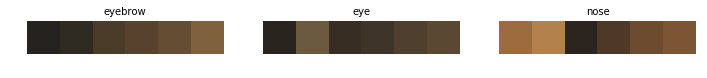

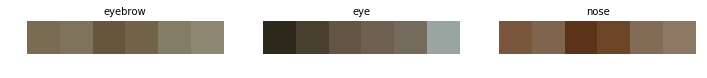

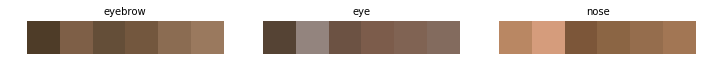

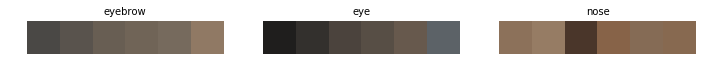

In [85]:
def try_it(face_path):
    image = cv2.imread(face_path)
    image_f = image.astype(float)
    rois = extract_face_parts(image, "shape_predictor_68_face_landmarks.dat")
    
    l = len(rois)
    f, ax = plt.subplots(1, l, figsize=(12, 12))
    
    assert l == 3
    
    scolors = ""
    for roi, title, i in zip(rois, ["eyebrow", "eye", "nose"], range(l)):
        (x, y, w, h) = roi
        face_part = image_f[y:y+h, x:x+w]
        colors = find_dominant_colors(face_part, 5)
        scolors = scolors + colors_as_string(colors) + ","
        
        pal = get_dominant_palette(colors)
        pal = pal.astype(np.uint8)
        
        ax[i].axis("off")
        ax[i].imshow(cv2.cvtColor(pal, cv2.COLOR_BGR2RGB))
        ax[i].set_title(title, fontsize=10)
        
    scolors = scolors[:-1]
    print scolors
    print "\n"
    
try_it("test_autumn.ppm")
try_it("test_spring.ppm")
try_it("test_summer.ppm")
try_it("test_winter.ppm")
       

In [96]:
def extract_dominant_colors(face_path):
    image = cv2.imread(face_path)
    if image == None:
        print(face_path)
    image_f = image.astype(float)
    rois = extract_face_parts(image, "shape_predictor_68_face_landmarks.dat")
    
    l = len(rois)
    
    if l < 3:
        return ""
    scolors = ""
    for roi in rois:
        (x, y, w, h) = roi
        face_part = image_f[y:y+h, x:x+w]
        colors = find_dominant_colors(face_part, 5)
        
        scolors = scolors + colors_as_string(colors) + ","
    
    return scolors[:-1]

def extract_colors():
    start = time.time()
    autumn_path = "./faces_only/autumn"
    spring_path = "./faces_only/spring"
    summer_path = "./faces_only/summer"
    winter_path = "./faces_only/winter"

    X, y = [], []

    # autumn = 0
    # spring = 1
    # summer = 2
    # winter = 3
    full_string = ""
    for i, season_path in enumerate([autumn_path, spring_path, summer_path, winter_path]):
        for fname in glob.glob(season_path + "/*"): # regex for front images
            full_string = full_string + fname + "," + str(i) + "," + extract_dominant_colors(fname) + "\n"
    
    file = open("face_dominant_colors.csv", "w")
    file.write(full_string)
    file.close()
    
    end = time.time()
    
    total = int(end - start)
    
    print("total time is {:d} seconds".format(total))
extract_colors()

/mnt/linux_shared/shared/anaconda2/envs/dlib/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/linux_shared/shared/anaconda2/envs/dlib/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice.
/home/sebastian/shared/anaconda2/envs/dlib/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/mnt/linux_shared/shared/anaconda2/envs/dlib/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in divide


total time is 1702 seconds
